In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set styling for visualizations
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [3]:
# Load the dataset
df = pd.read_csv('CC GENERAL.csv')

In [4]:
# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {df.shape}")

Dataset Information:
Shape: (8950, 18)


In [5]:
print("\nData Types:")
print(df.dtypes)


Data Types:
CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object


In [6]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000

In [7]:
# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values:
CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64


In [8]:
# Data Preprocessing
# 1. Handling missing values
# For CREDIT_LIMIT, fill with median since there's only 1 missing value
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)

In [9]:
# For MINIMUM_PAYMENTS, more missing values, also fill with median
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

In [10]:
# 2. Remove the customer ID as it's not needed for clustering
df_cluster = df.drop('CUST_ID', axis=1)

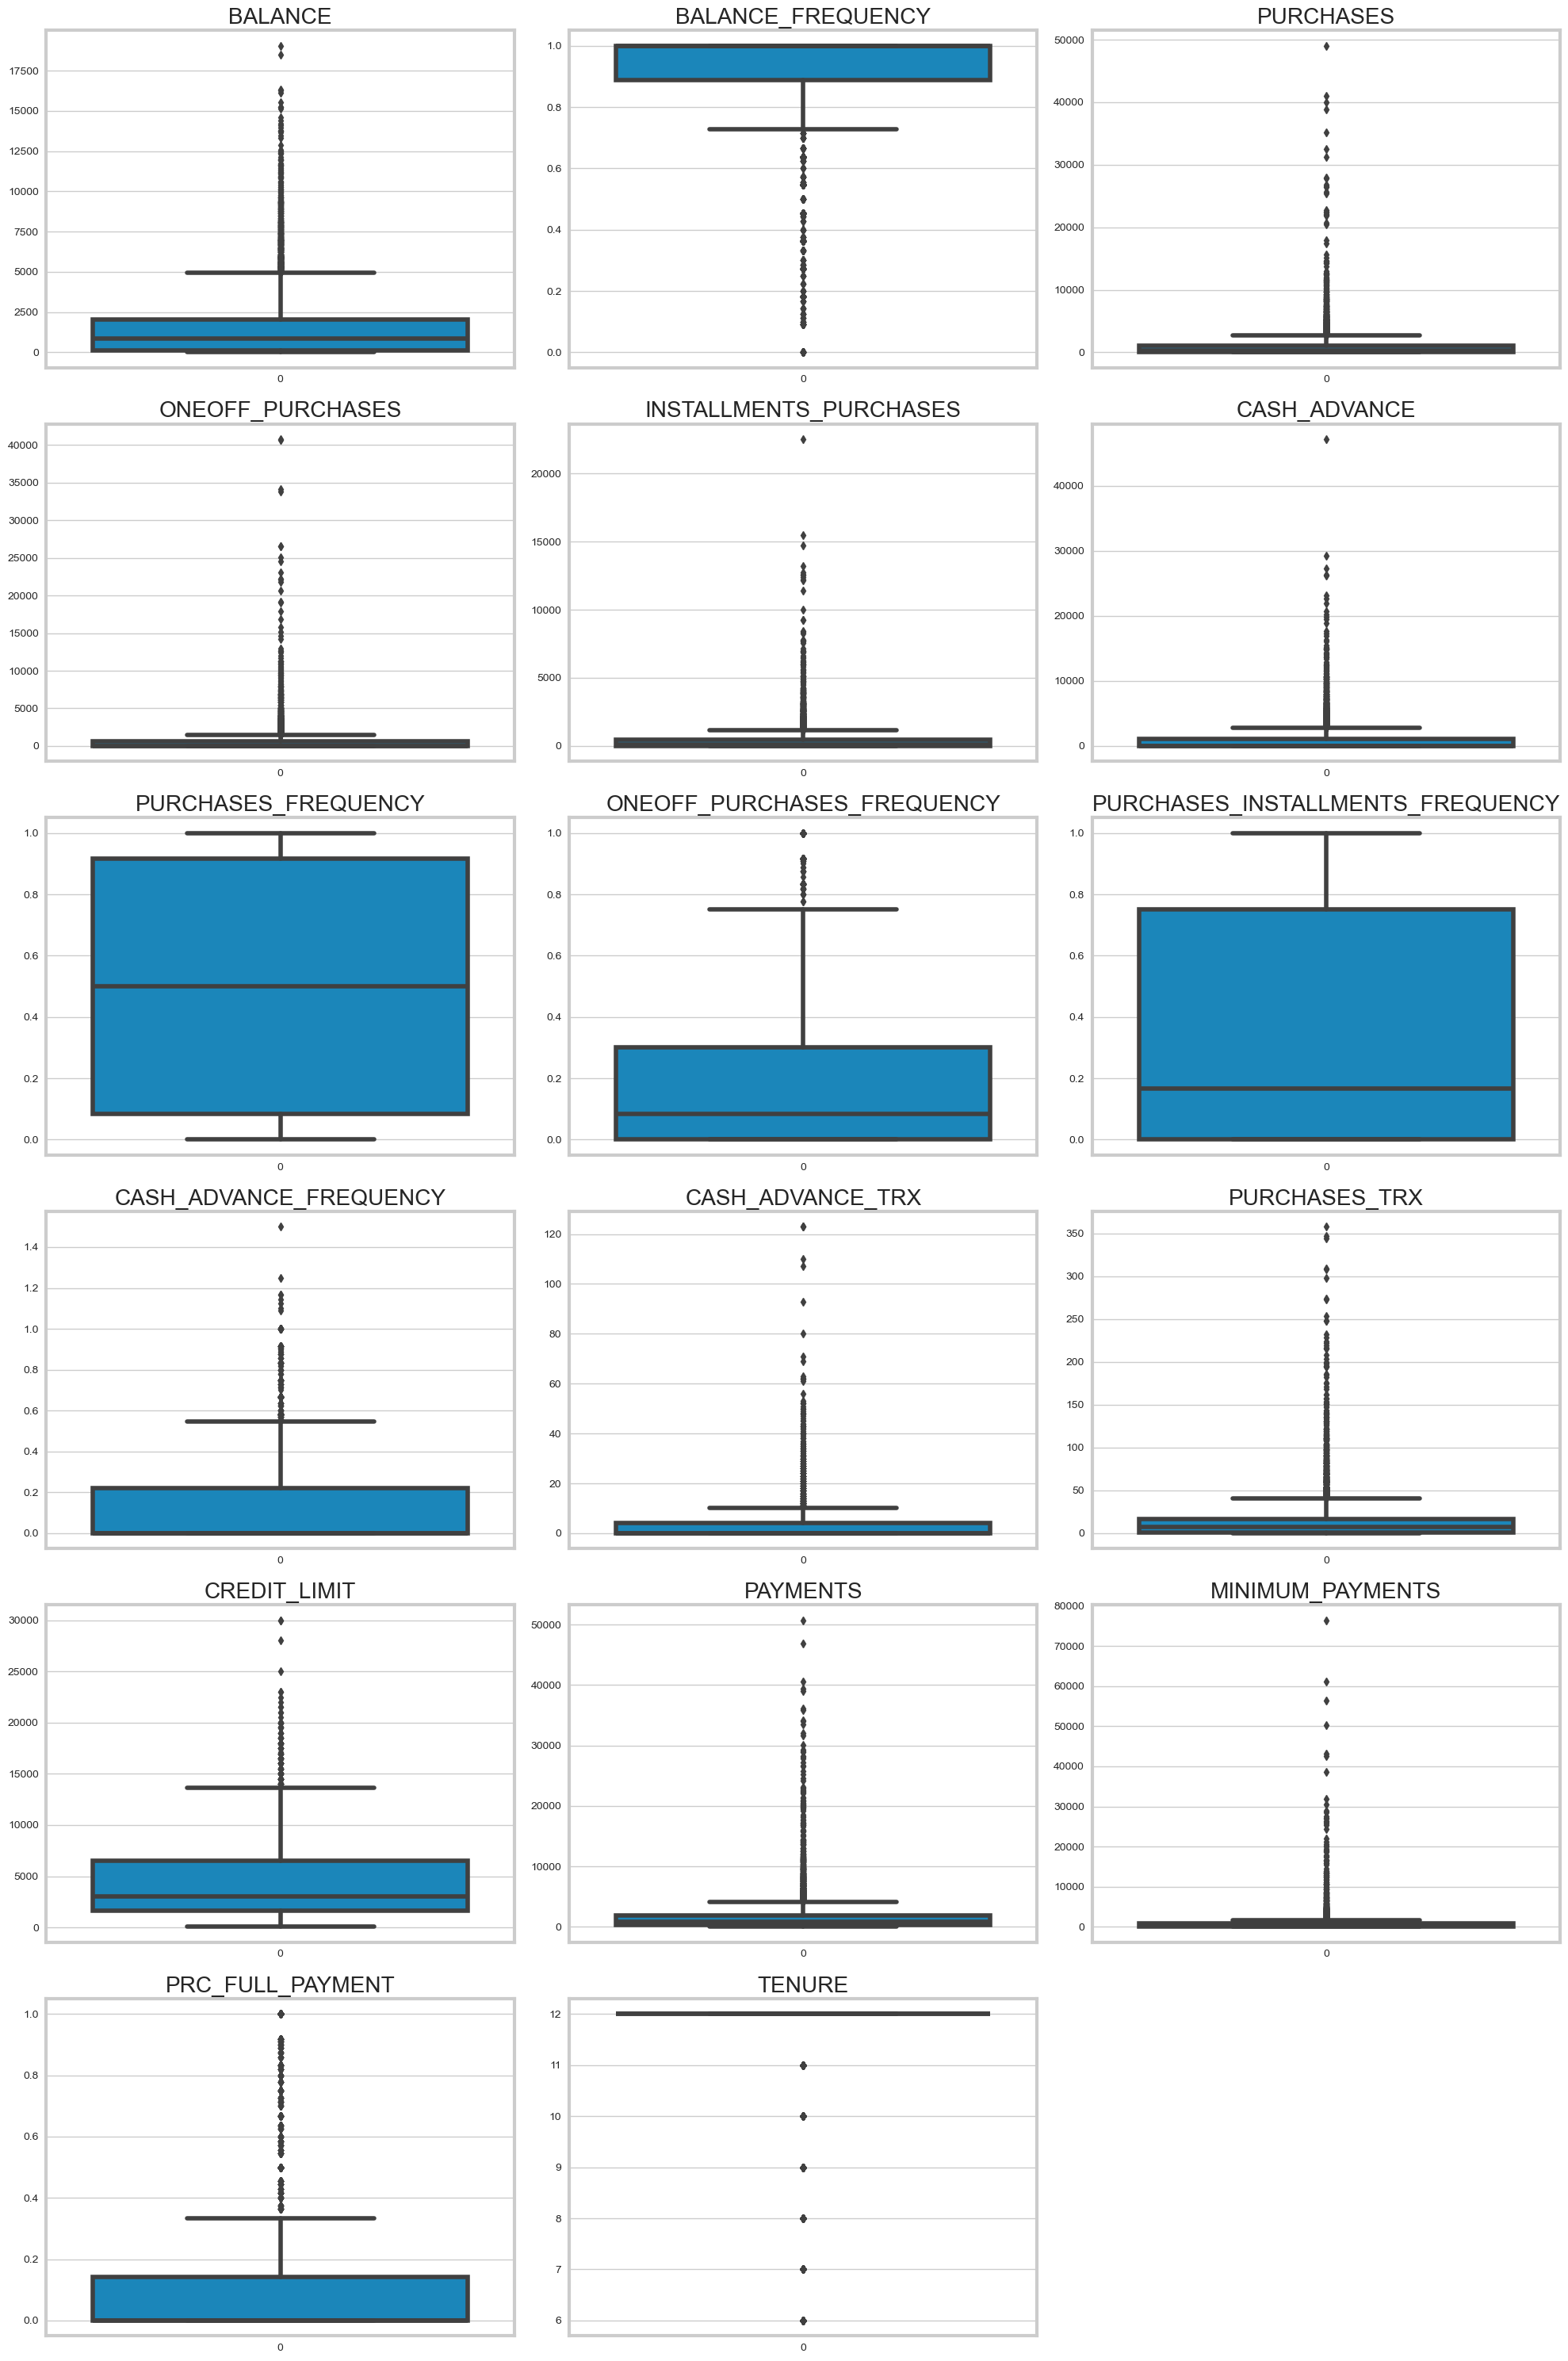

In [11]:
# 3. Check for outliers using boxplots
plt.figure(figsize=(20, 30))
for i, column in enumerate(df_cluster.columns):
    plt.subplot(6, 3, i+1)
    sns.boxplot(df_cluster[column])
    plt.title(column)
plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

In [12]:
# 4. Handle outliers using IQR method for key variables
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

In [13]:
# Apply outlier handling to columns with significant outliers
columns_with_outliers = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
                         'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 
                         'PAYMENTS', 'MINIMUM_PAYMENTS']

for column in columns_with_outliers:
    df_cluster = handle_outliers(df_cluster, column)

In [14]:
# 5. Scale the data for clustering
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cluster), columns=df_cluster.columns)

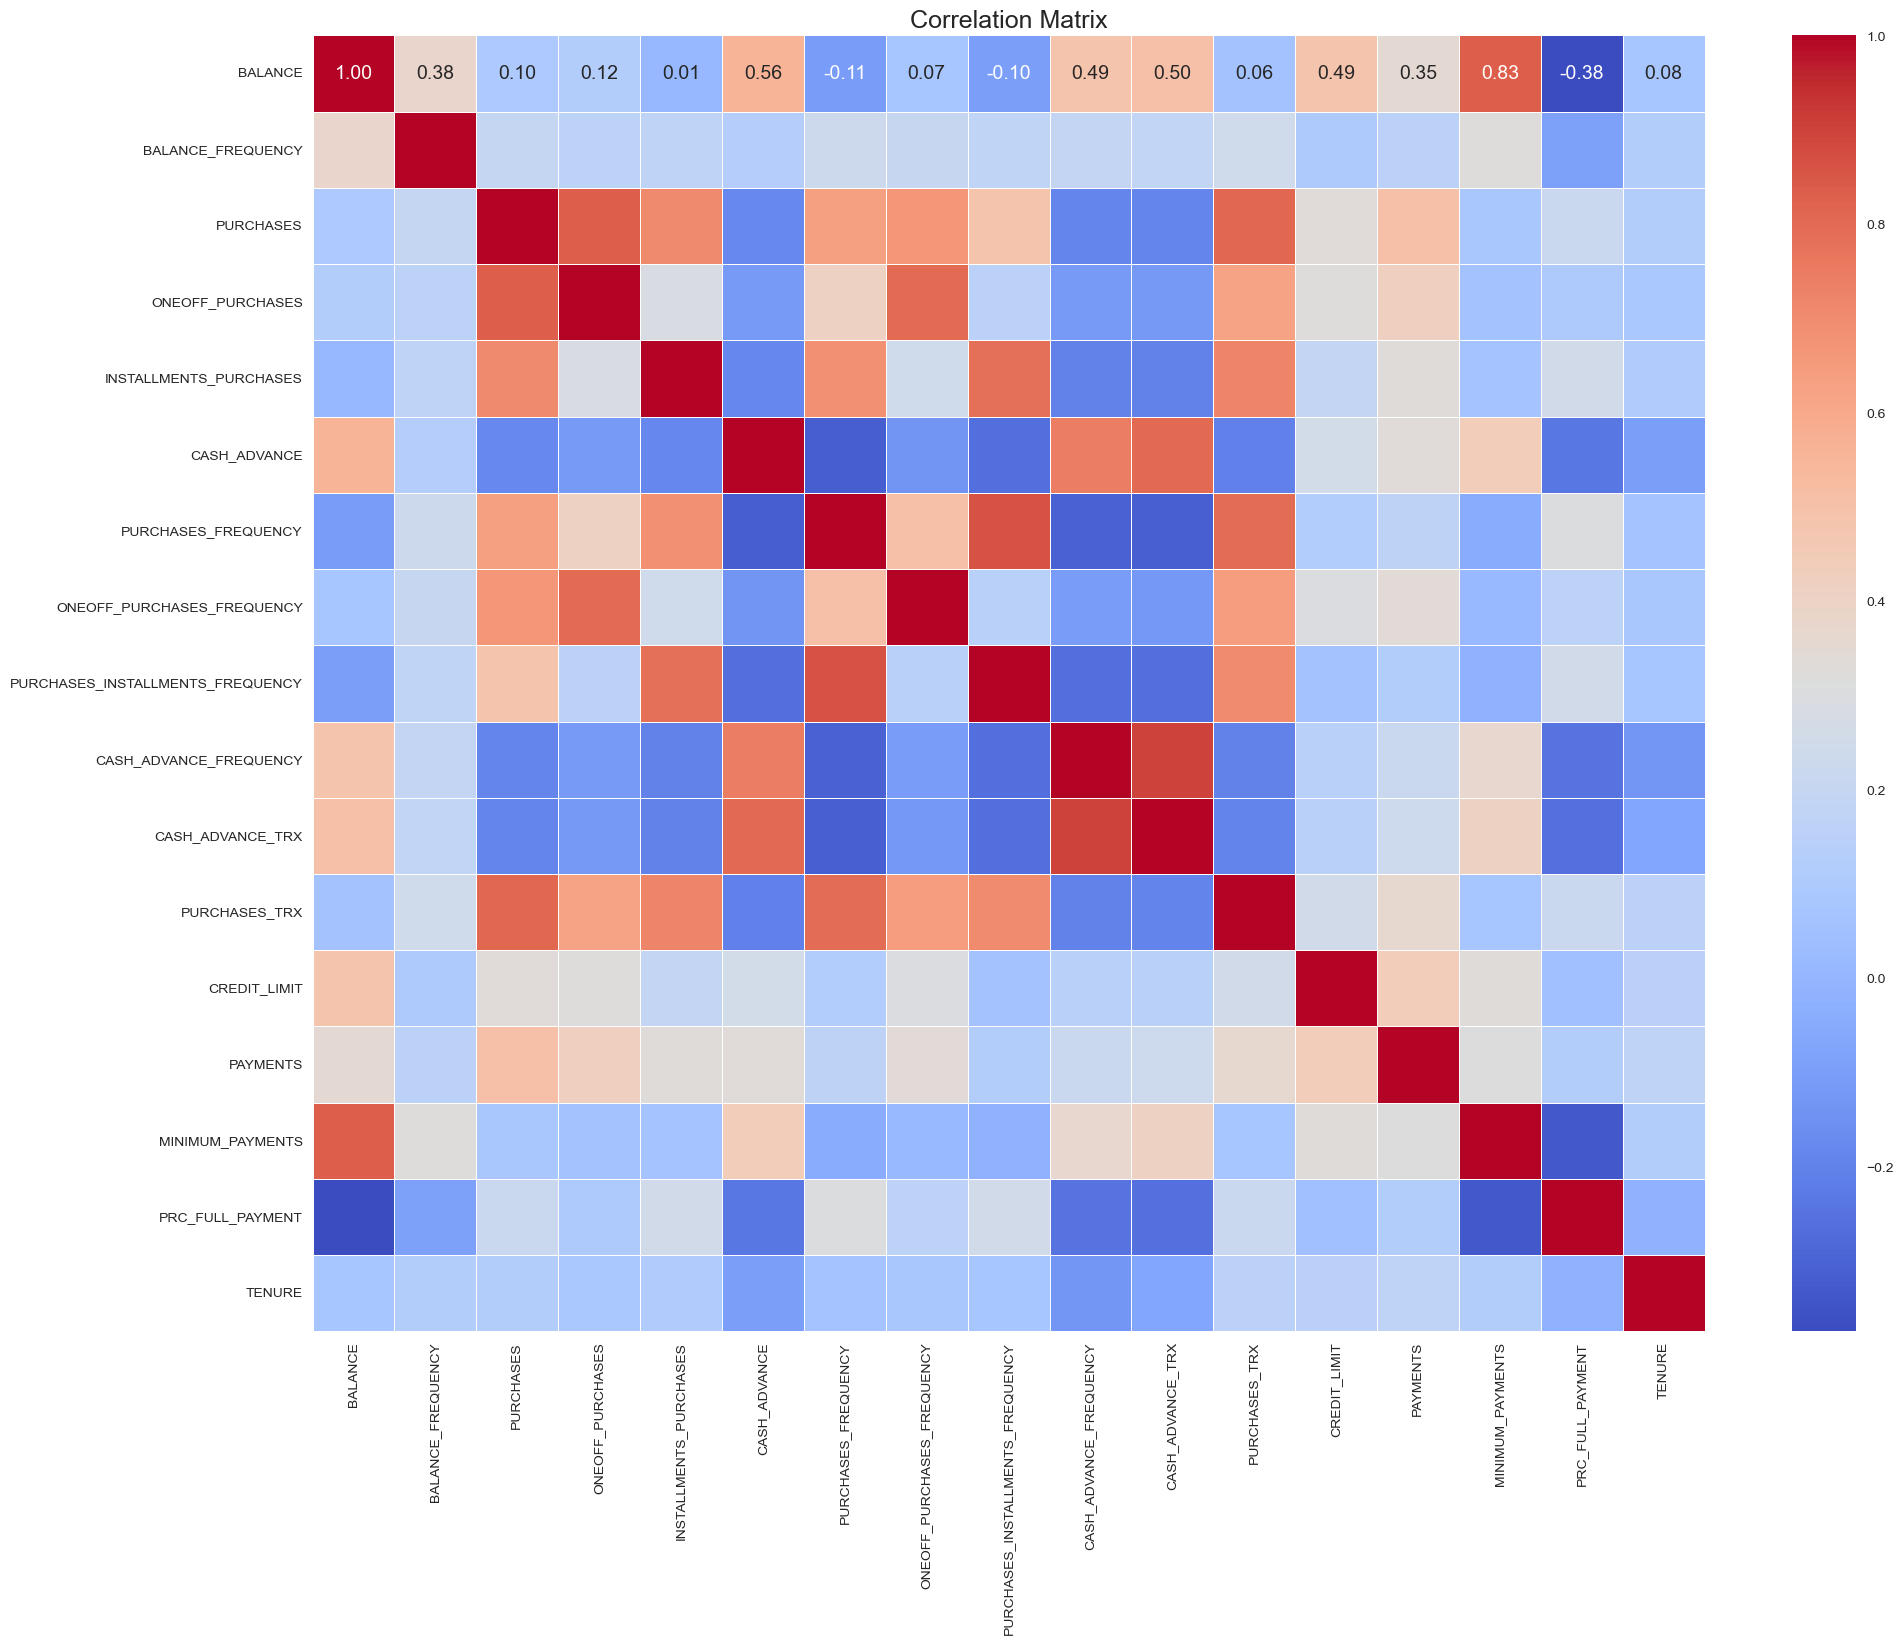

In [15]:
# EDA: Correlation Analysis
plt.figure(figsize=(20, 16))
correlation_matrix = df_cluster.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=18)
plt.savefig('correlation_matrix.png')
plt.show()

In [16]:
# Dimensionality Reduction with PCA
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

In [17]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

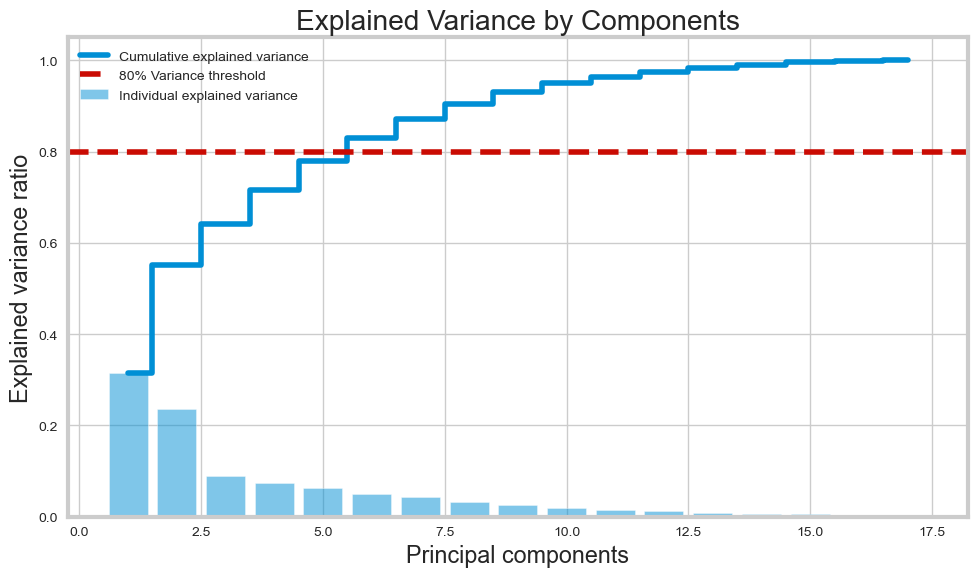

In [18]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance threshold')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance by Components')
plt.legend()
plt.tight_layout()
plt.savefig('pca_explained_variance.png')
plt.show()

In [19]:
# Determine optimal number of components (e.g., components needed to explain 80% variance)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"\nNumber of PCA components explaining 80% variance: {n_components}")


Number of PCA components explaining 80% variance: 6


In [20]:
# Apply PCA with the optimal number of components
pca = PCA(n_components=n_components)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), 
                      columns=[f'PC{i+1}' for i in range(n_components)])
print("\nPCA Components Shape:", df_pca.shape)


PCA Components Shape: (8950, 6)


In [21]:
# t-SNE for visualization
print("\nApplying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(df_scaled)
df_tsne = pd.DataFrame(data=tsne_results, columns=['t-SNE 1', 't-SNE 2'])


Applying t-SNE for visualization...


In [22]:
# Function to visualize clusters
def plot_clusters(df, labels, title, filename):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['t-SNE 1'], df['t-SNE 2'], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [23]:
# Function to get cluster profiles
def get_cluster_profiles(df_original, labels):
    df_with_clusters = df_original.copy()
    df_with_clusters['Cluster'] = labels
    
    cluster_profiles = df_with_clusters.groupby('Cluster').mean()
    
    # Calculate cluster sizes
    cluster_sizes = df_with_clusters['Cluster'].value_counts().sort_index()
    
    return cluster_profiles, cluster_sizes

In [24]:
# 1. K-Means Clustering
print("\n## K-Means Clustering ##")

# Find optimal K using elbow method
plt.figure(figsize=(10, 6))
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 15))
visualizer.fit(df_scaled)
visualizer.show(outpath='kmeans_elbow.png')
plt.close()

optimal_k = visualizer.elbow_value_
if optimal_k is None:
    optimal_k = 5  # Default if no clear elbow
    
print(f"Optimal number of clusters (K-Means): {optimal_k}")


## K-Means Clustering ##
Optimal number of clusters (K-Means): 8


In [25]:
# Apply K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

In [26]:
# Calculate silhouette score
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

K-Means Silhouette Score: 0.2060


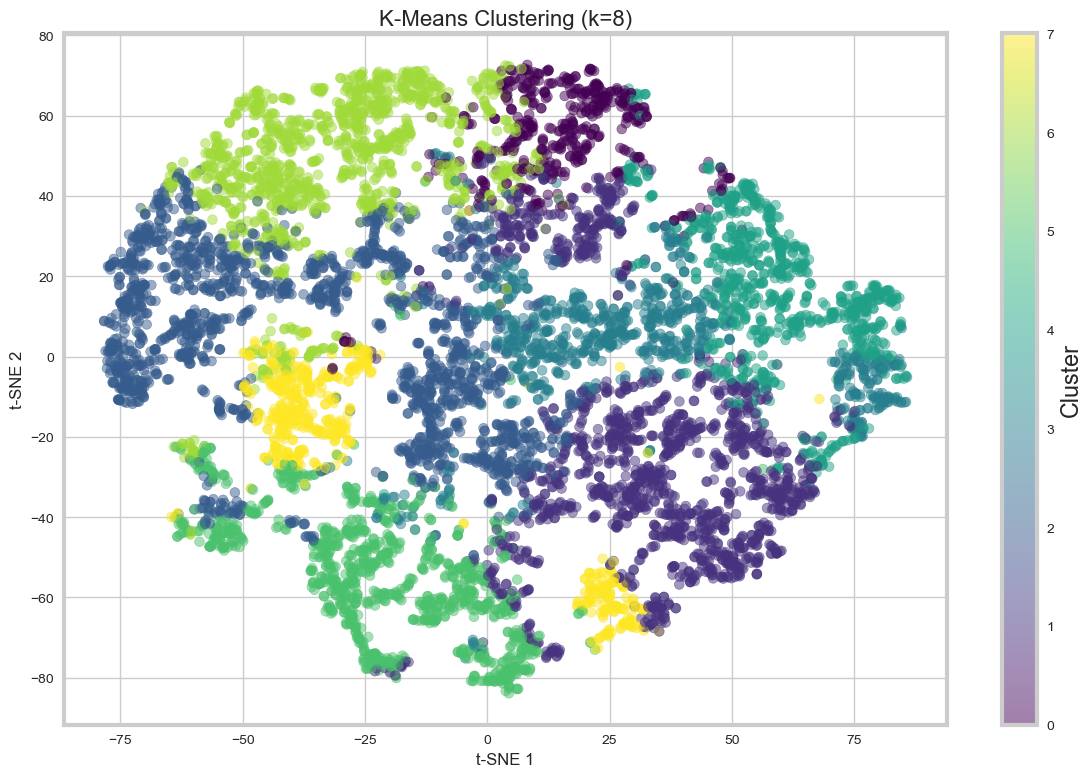

In [27]:
# Visualize K-Means clusters using t-SNE
plot_clusters(df_tsne, kmeans_labels, f'K-Means Clustering (k={optimal_k})', 'kmeans_clusters.png')

In [28]:
# Get K-Means cluster profiles
kmeans_profiles, kmeans_sizes = get_cluster_profiles(df_cluster, kmeans_labels)
print("\nK-Means Cluster Sizes:")
print(kmeans_sizes)
print("\nK-Means Cluster Profiles:")
print(kmeans_profiles)


K-Means Cluster Sizes:
Cluster
0     487
1    1697
2    2009
3     908
4     911
5    1101
6    1279
7     558
Name: count, dtype: int64

K-Means Cluster Profiles:
             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        3721.727320           0.982116  1668.357002        766.861828   
1         569.152778           0.947583   784.785632         94.635427   
2        1252.265718           0.973011   148.610149        104.910229   
3        1108.433591           0.942857  1364.483552       1031.104802   
4        1713.641619           0.980377  2486.178751       1212.501232   
5          80.663459           0.359195   271.911199        146.138583   
6        3202.447256           0.959831   146.414318        107.118745   
7         714.326682           0.785162   294.192800        157.611873   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                 


## Hierarchical Clustering ##


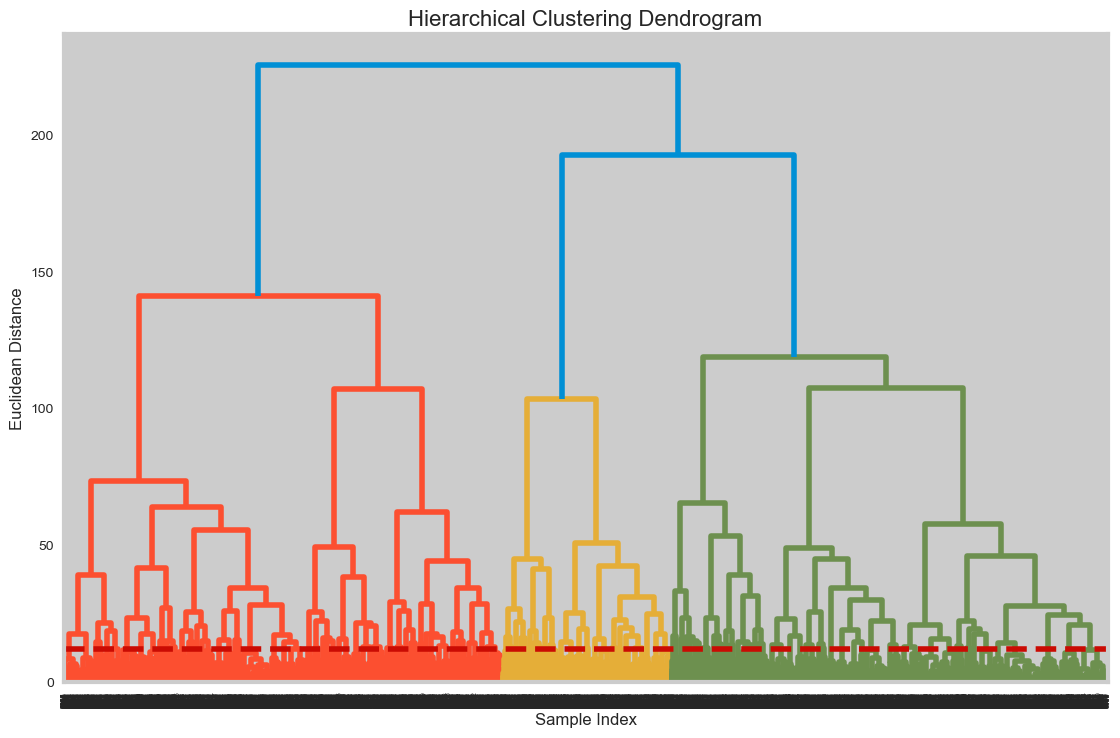

In [29]:
# 2. Hierarchical Clustering
print("\n## Hierarchical Clustering ##")

# Create dendrogram to find optimal number of clusters
plt.figure(figsize=(12, 8))
dendrogram = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.axhline(y=12, color='r', linestyle='--')  # This threshold can be adjusted based on dendrogram
plt.savefig('hierarchical_dendrogram.png')
plt.show()

In [30]:
# Determine optimal clusters from dendrogram (visual inspection)
optimal_h_clusters = optimal_k  # Use same as K-means for comparison

In [31]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_h_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(df_scaled)

In [32]:
# Calculate silhouette score
hierarchical_silhouette = silhouette_score(df_scaled, hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.4f}")

Hierarchical Clustering Silhouette Score: 0.1484


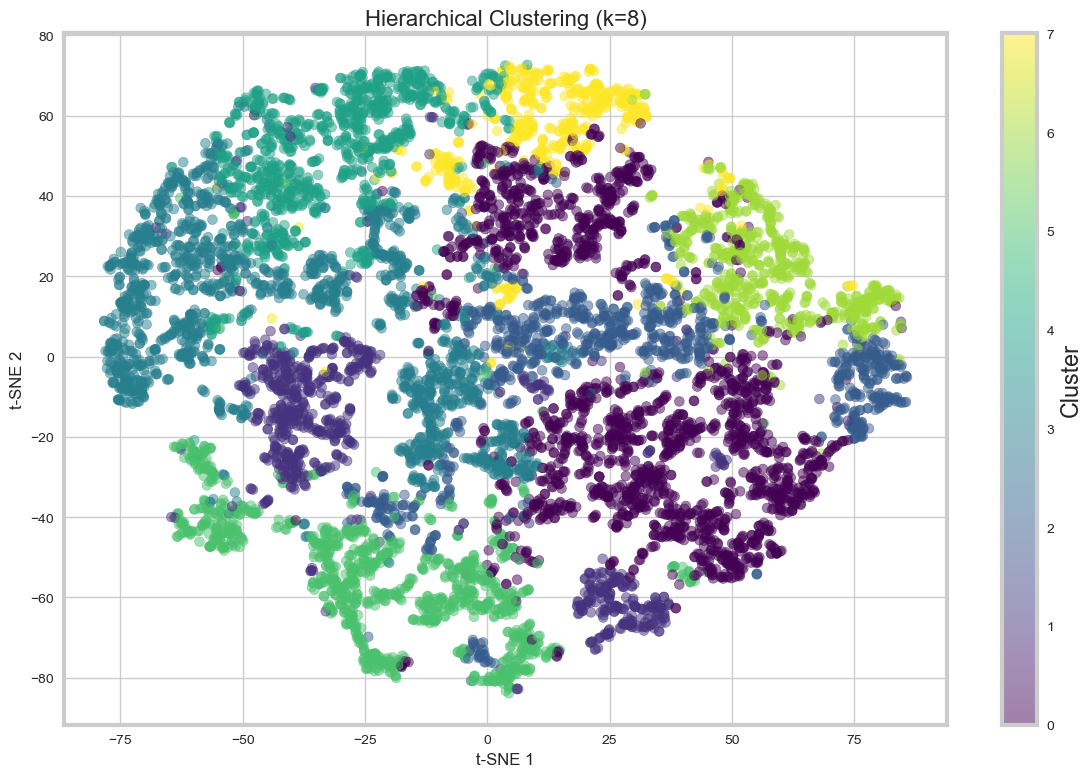

In [33]:
# Visualize Hierarchical clusters using t-SNE
plot_clusters(df_tsne, hierarchical_labels, f'Hierarchical Clustering (k={optimal_h_clusters})', 'hierarchical_clusters.png')

In [34]:
# Get Hierarchical cluster profiles
hierarchical_profiles, hierarchical_sizes = get_cluster_profiles(df_cluster, hierarchical_labels)
print("\nHierarchical Cluster Sizes:")
print(hierarchical_sizes)
print("\nHierarchical Cluster Profiles:")
print(hierarchical_profiles)


Hierarchical Cluster Sizes:
Cluster
0    2087
1     832
2    1013
3    1774
4     985
5    1128
6     670
7     461
Name: count, dtype: int64

Hierarchical Cluster Profiles:
             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0         973.264997           0.964321   899.455604        163.074576   
1         825.359419           0.767492   392.906364        191.421184   
2         933.118844           0.897295  1325.554430        990.647080   
3        1331.024950           0.983436   117.672446         91.307627   
4        3389.877076           0.972973    97.018152         79.033320   
5         123.624934           0.422614   233.679894         85.111356   
6        1914.080582           0.984133  2567.841108       1365.075806   
7        3600.331323           0.981450  1653.535054        906.609187   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster       

In [35]:
# 3. DBSCAN Clustering
print("\n## DBSCAN Clustering ##")

# Find optimal epsilon using k-distance graph
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Sort distances for k-distance graph
distances = np.sort(distances[:, -1])


## DBSCAN Clustering ##


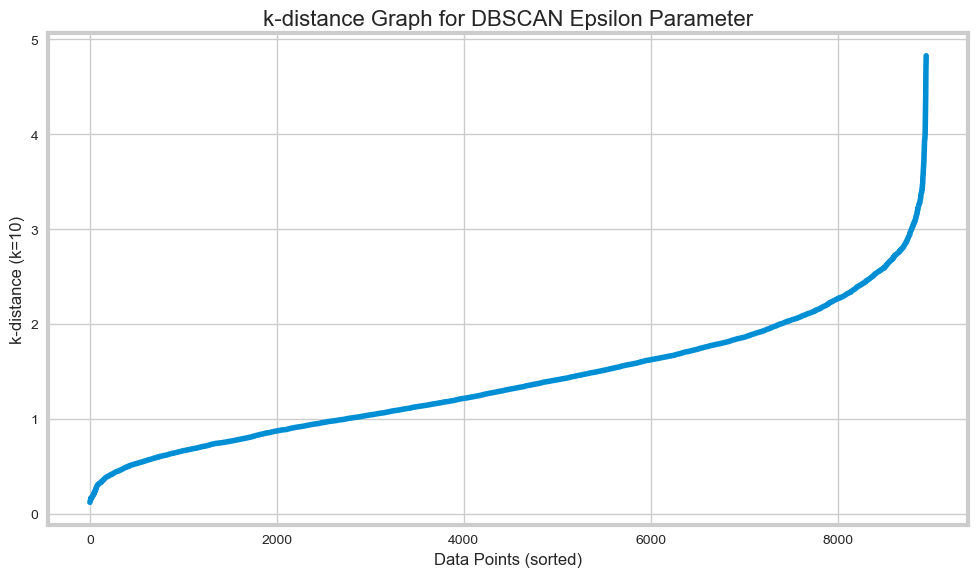

In [36]:
# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted)', fontsize=12)
plt.ylabel('k-distance (k=10)', fontsize=12)
plt.title('k-distance Graph for DBSCAN Epsilon Parameter', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('dbscan_kdistance.png')
plt.show()

In [37]:
# Based on k-distance graph, choose epsilon at the "elbow"
epsilon = 1.0  # This should be adjusted based on the k-distance graph
min_samples = 5  # Min points to form a core point

In [38]:
# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_scaled)

In [39]:
# Number of clusters (excluding noise points labeled as -1)
dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN number of clusters: {dbscan_n_clusters}")
print(f"DBSCAN noise points: {list(dbscan_labels).count(-1)}")

DBSCAN number of clusters: 30
DBSCAN noise points: 4337


In [40]:
# If DBSCAN produced more than one cluster, calculate silhouette score
if dbscan_n_clusters > 1 and -1 not in dbscan_labels:
    dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
elif dbscan_n_clusters > 1:
    # Filter out noise points for silhouette score calculation
    mask = dbscan_labels != -1
    dbscan_silhouette = silhouette_score(df_scaled[mask], dbscan_labels[mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")
else:
    print("DBSCAN: Cannot calculate silhouette score with 0 or 1 cluster")

DBSCAN Silhouette Score (excluding noise): -0.3119


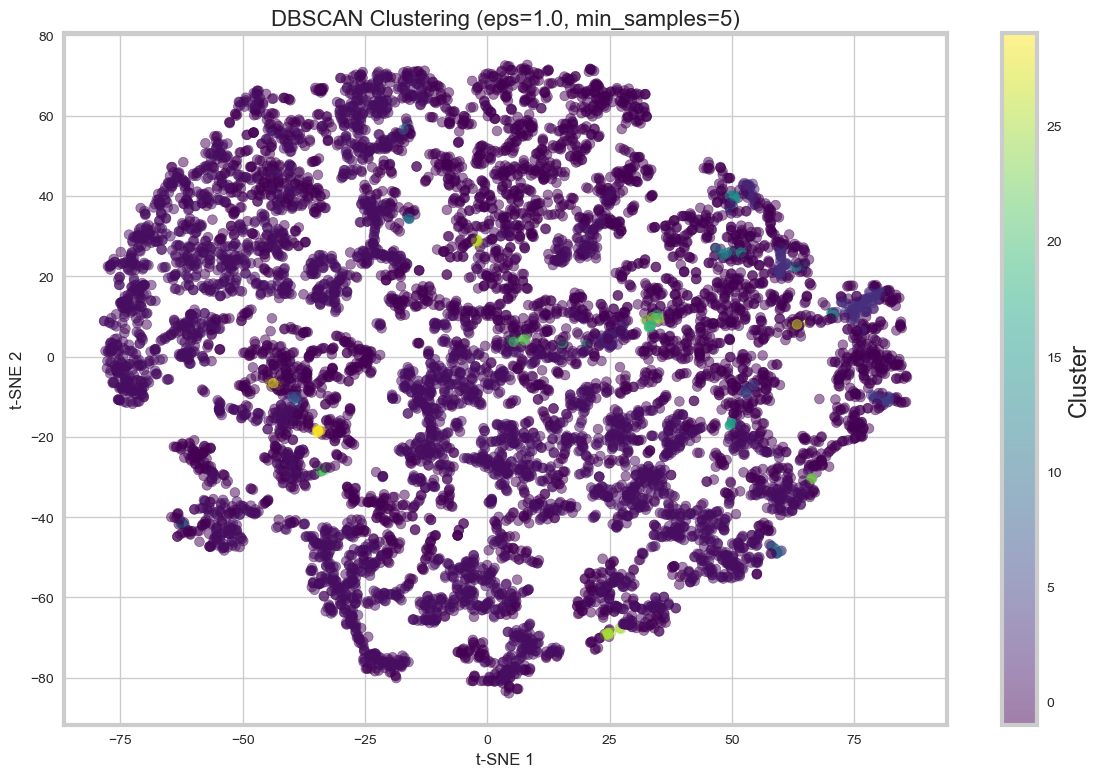

In [41]:
# Visualize DBSCAN clusters using t-SNE
plot_clusters(df_tsne, dbscan_labels, f'DBSCAN Clustering (eps={epsilon}, min_samples={min_samples})', 'dbscan_clusters.png')

In [42]:
# Get DBSCAN cluster profiles (excluding noise points)
if -1 in dbscan_labels:
    df_valid = df_cluster.copy()
    df_valid['Cluster'] = dbscan_labels
    df_valid = df_valid[df_valid['Cluster'] != -1]
    
    if not df_valid.empty and len(set(df_valid['Cluster'])) > 0:
        dbscan_profiles = df_valid.groupby('Cluster').mean()
        dbscan_sizes = df_valid['Cluster'].value_counts().sort_index()
        
        print("\nDBSCAN Cluster Sizes (excluding noise):")
        print(dbscan_sizes)
        print("\nDBSCAN Cluster Profiles (excluding noise):")
        print(dbscan_profiles)
    else:
        print("\nNo valid DBSCAN clusters to display")
else:
    dbscan_profiles, dbscan_sizes = get_cluster_profiles(df_cluster, dbscan_labels)
    print("\nDBSCAN Cluster Sizes:")
    print(dbscan_sizes)
    print("\nDBSCAN Cluster Profiles:")
    print(dbscan_profiles)


DBSCAN Cluster Sizes (excluding noise):
Cluster
0     4284
1       40
2       31
3       96
4       21
5        6
6        6
7        6
8        5
9       10
10       5
11       5
12       6
13       8
14      10
15       5
16       4
17       4
18       1
19       7
20       4
21       6
22       5
23       3
24       5
25       9
26       5
27       5
28       5
29       6
Name: count, dtype: int64

DBSCAN Cluster Profiles (excluding noise):
             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        1069.221861           0.859405   247.045141         74.263970   
1         250.945020           0.990909   536.889750        528.295250   
2        4875.134991           1.000000  2715.872500       1442.884677   
3         953.173763           1.000000  2714.848932       1441.528568   
4          59.380483           0.991342   646.997619        638.149048   
5        4724.600808           1.

In [43]:
# 4. Gaussian Mixture Model (GMM)
print("\n## Gaussian Mixture Model (GMM) ##")

# Find optimal number of components using BIC
n_components_range = range(2, 15)
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df_scaled)
    bic_scores.append(gmm.bic(df_scaled))


## Gaussian Mixture Model (GMM) ##


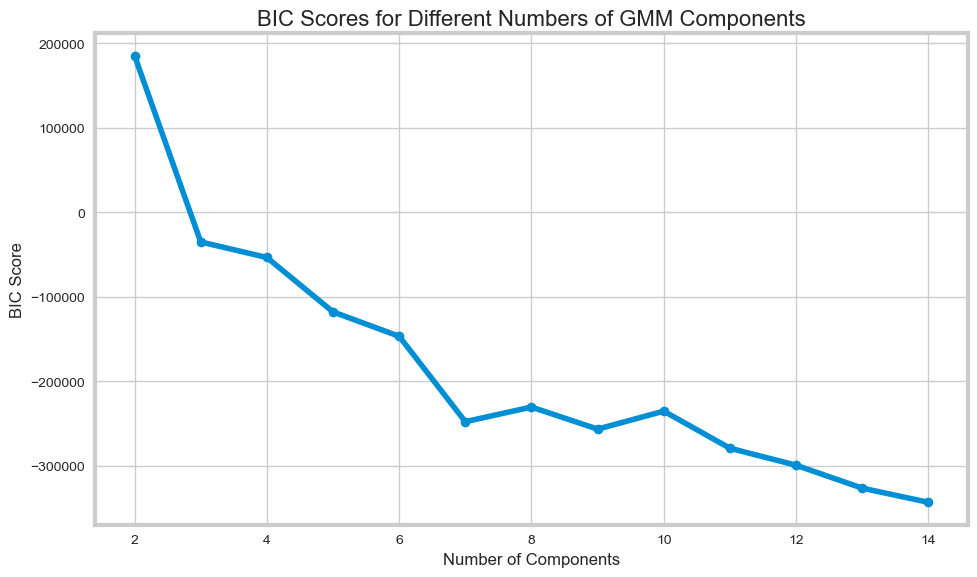

In [44]:
# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('BIC Score', fontsize=12)
plt.title('BIC Scores for Different Numbers of GMM Components', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('gmm_bic.png')
plt.show()

In [45]:
# Choose optimal number of components based on BIC
optimal_gmm_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components for GMM: {optimal_gmm_components}")

Optimal number of components for GMM: 14


In [46]:
# Apply GMM with optimal components
gmm = GaussianMixture(n_components=optimal_gmm_components, random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)

In [47]:
# Calculate silhouette score
gmm_silhouette = silhouette_score(df_scaled, gmm_labels)
print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")

GMM Silhouette Score: 0.0306


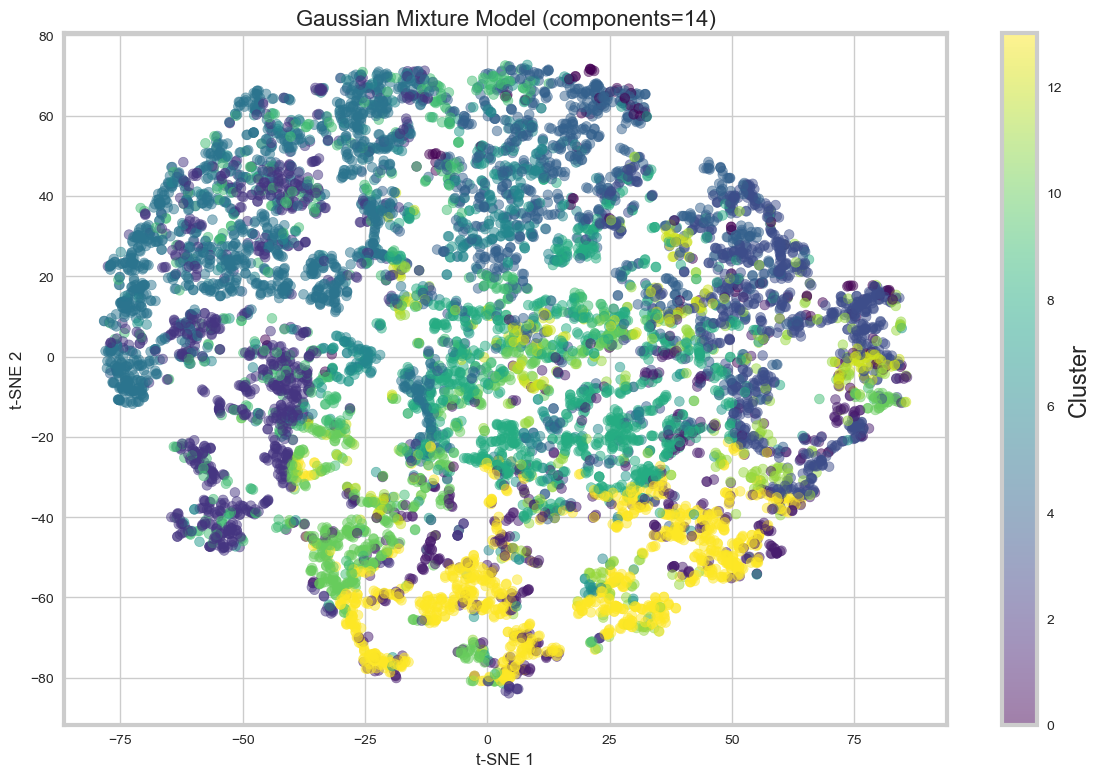

In [48]:
# Visualize GMM clusters using t-SNE
plot_clusters(df_tsne, gmm_labels, f'Gaussian Mixture Model (components={optimal_gmm_components})', 'gmm_clusters.png')

In [49]:
# Get GMM cluster profiles
gmm_profiles, gmm_sizes = get_cluster_profiles(df_cluster, gmm_labels)
print("\nGMM Cluster Sizes:")
print(gmm_sizes)
print("\nGMM Cluster Profiles:")
print(gmm_profiles)


GMM Cluster Sizes:
Cluster
0      119
1      468
2      937
3      876
4      896
5     1447
6      382
7      179
8     1068
9      475
10     548
11     310
12     210
13    1035
Name: count, dtype: int64

GMM Cluster Profiles:
             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        1692.100256           0.884573  2336.923109       1220.318824   
1         135.951894           0.765540   746.830812        301.021026   
2        1280.544248           0.744264     0.000000          0.000000   
3        1404.391215           1.000000  2253.418325        965.762018   
4        2693.583852           1.000000  1465.779886        712.599858   
5        2381.950311           1.000000    33.143552         33.143552   
6        2229.333583           0.964344   339.793796         20.269476   
7        1103.217919           0.831459   784.660112        384.400670   
8        1302.684518         

In [50]:
# Compare clustering methods
print("\n## Clustering Methods Comparison ##")
clustering_methods = ['K-Means', 'Hierarchical', 'DBSCAN', 'GMM']
silhouette_scores = [kmeans_silhouette, hierarchical_silhouette]

if 'dbscan_silhouette' in locals():
    silhouette_scores.append(dbscan_silhouette)
else:
    silhouette_scores.append(0)  # If DBSCAN silhouette wasn't calculated

silhouette_scores.append(gmm_silhouette)


## Clustering Methods Comparison ##


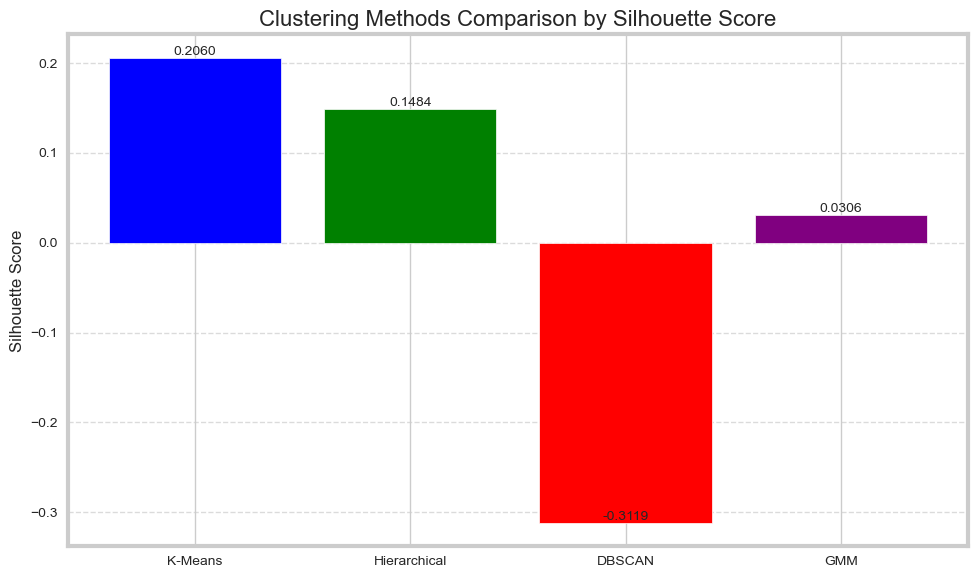

In [51]:
# Plot silhouette scores comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(clustering_methods, silhouette_scores, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Clustering Methods Comparison by Silhouette Score', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add silhouette values on top of bars
for bar, score in zip(bars, silhouette_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('clustering_comparison.png')
plt.show()

In [52]:
# Feature importance for the best clustering method
# Use the best method based on silhouette score
best_method_index = np.argmax(silhouette_scores)
best_method = clustering_methods[best_method_index]
print(f"\nBest clustering method based on silhouette score: {best_method}")


Best clustering method based on silhouette score: K-Means


In [53]:
# Get labels from best method
if best_method == 'K-Means':
    best_labels = kmeans_labels
elif best_method == 'Hierarchical':
    best_labels = hierarchical_labels
elif best_method == 'DBSCAN':
    best_labels = dbscan_labels
else:  # GMM
    best_labels = gmm_labels

In [54]:
# Add cluster labels to the original data
df_with_clusters = df_cluster.copy()
df_with_clusters['Cluster'] = best_labels

In [55]:
# For each cluster, find the most distinctive features
cluster_profiles = df_with_clusters.groupby('Cluster').mean()
overall_mean = df_cluster.mean()

In [56]:
# Calculate how each feature deviates from the overall mean for each cluster
deviations = cluster_profiles.sub(overall_mean, axis=1)
abs_deviations = deviations.abs()

In [57]:
# For each cluster, find top 3 distinctive features
distinctive_features = {}
for cluster in cluster_profiles.index:
    cluster_deviations = abs_deviations.loc[cluster]
    top_features = cluster_deviations.nlargest(3).index.tolist()
    distinctive_features[cluster] = top_features

print("\nMost distinctive features for each cluster:")
for cluster, features in distinctive_features.items():
    print(f"Cluster {cluster}: {', '.join(features)}")


Most distinctive features for each cluster:
Cluster 0: CREDIT_LIMIT, BALANCE, CASH_ADVANCE
Cluster 1: CREDIT_LIMIT, BALANCE, CASH_ADVANCE
Cluster 2: CREDIT_LIMIT, PAYMENTS, PURCHASES
Cluster 3: ONEOFF_PURCHASES, PURCHASES, CREDIT_LIMIT
Cluster 4: CREDIT_LIMIT, PURCHASES, PAYMENTS
Cluster 5: BALANCE, CREDIT_LIMIT, PAYMENTS
Cluster 6: CREDIT_LIMIT, BALANCE, CASH_ADVANCE
Cluster 7: CREDIT_LIMIT, PAYMENTS, BALANCE


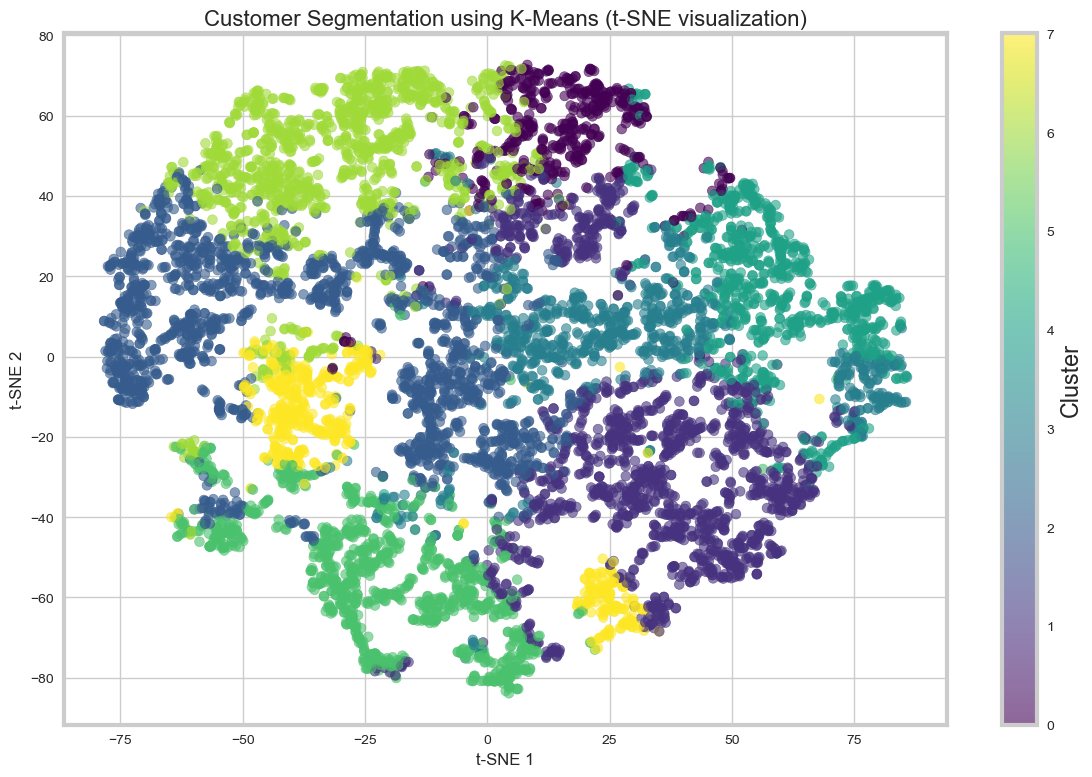

In [58]:
# Final cluster visualization for the best method
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_tsne['t-SNE 1'], df_tsne['t-SNE 2'], c=best_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Customer Segmentation using {best_method} (t-SNE visualization)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.tight_layout()
plt.savefig('best_clustering_method.png')
plt.show()

In [59]:
# Cluster Customer Profiles
print("\n## Customer Segment Profiles ##")
print(cluster_profiles)


## Customer Segment Profiles ##
             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        3721.727320           0.982116  1668.357002        766.861828   
1         569.152778           0.947583   784.785632         94.635427   
2        1252.265718           0.973011   148.610149        104.910229   
3        1108.433591           0.942857  1364.483552       1031.104802   
4        1713.641619           0.980377  2486.178751       1212.501232   
5          80.663459           0.359195   271.911199        146.138583   
6        3202.447256           0.959831   146.414318        107.118745   
7         714.326682           0.785162   294.192800        157.611873   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                    675.459451   2202.806192             0.851587   
1               

In [60]:
# Radar chart for cluster profiles visualization
def radar_chart(cluster_profiles):
    # Normalize the data for radar chart
    scaler = StandardScaler()
    scaled_profiles = pd.DataFrame(scaler.fit_transform(cluster_profiles), 
                                  index=cluster_profiles.index, 
                                  columns=cluster_profiles.columns)
    
    # Set up the figure
    fig = plt.figure(figsize=(12, 10))
    
    # Number of variables
    categories = list(scaled_profiles.columns)
    N = len(categories)
    
    # Create a list of angles for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create subplot for each cluster
    num_clusters = len(scaled_profiles)
    rows = int(np.ceil(num_clusters / 2))
    
    for i, cluster in enumerate(scaled_profiles.index):
        ax = fig.add_subplot(rows, 2, i+1, polar=True)
        
        # Values for this cluster
        values = scaled_profiles.loc[cluster].values.tolist()
        values += values[:1]  # Close the loop
        
        # Draw the chart
        ax.plot(angles, values, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)
        
        # Set labels and title
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=8)
        ax.set_title(f'Cluster {cluster} Profile', size=14)
        
    plt.tight_layout()
    plt.savefig('cluster_radar_charts.png')
    plt.show()

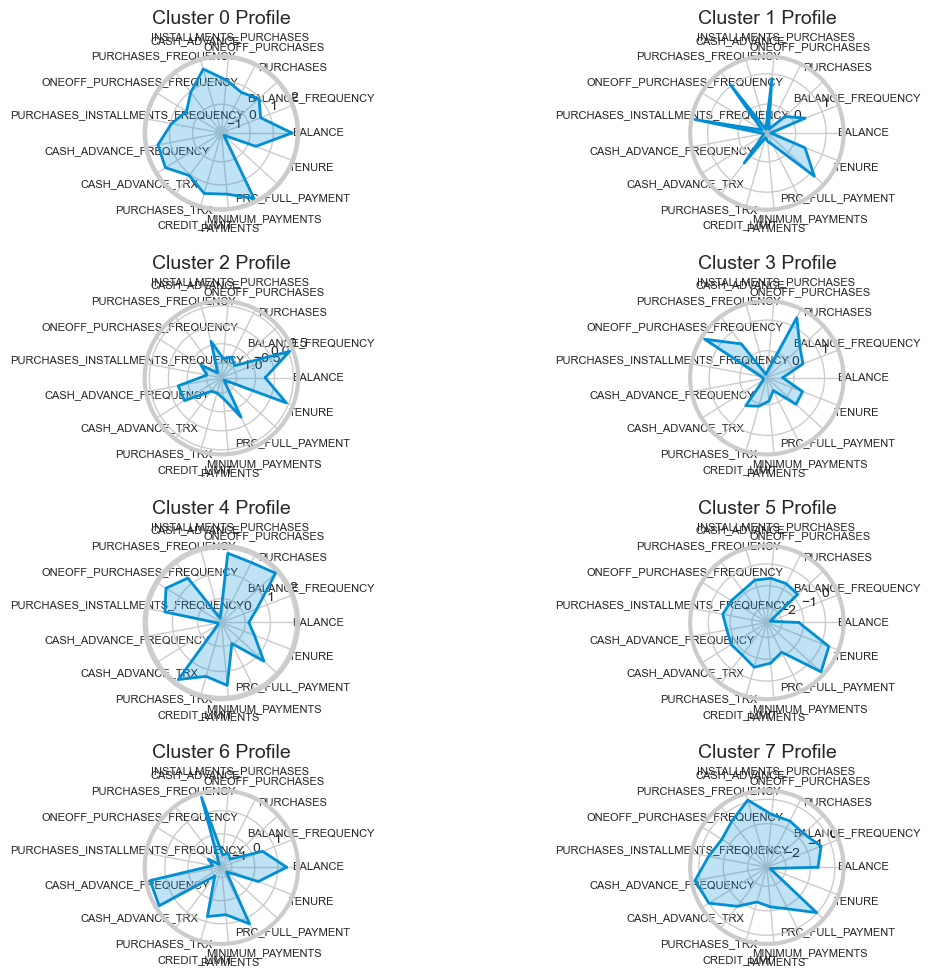

In [61]:
# Create radar charts for cluster profiles
radar_chart(cluster_profiles)

In [62]:
print("\n## Customer Segmentation Analysis Complete ##")
print("Clustering methods used: K-Means, Hierarchical Clustering, DBSCAN, and GMM")
print("Visualizations created using t-SNE")
print(f"Best clustering method: {best_method}")


## Customer Segmentation Analysis Complete ##
Clustering methods used: K-Means, Hierarchical Clustering, DBSCAN, and GMM
Visualizations created using t-SNE
Best clustering method: K-Means


In [63]:
# Final summary of findings
print("\n## Summary of Customer Segments ##")
for cluster in cluster_profiles.index:
    top_features = distinctive_features[cluster]
    print(f"\nCluster {cluster} - Size: {df_with_clusters['Cluster'].value_counts()[cluster]}")
    print(f"Distinctive features: {', '.join(top_features)}")
    
    feature_values = []
    for feature in top_features:
        avg_value = cluster_profiles.loc[cluster, feature]
        overall_avg = overall_mean[feature]
        comparison = "higher than" if avg_value > overall_avg else "lower than"
        feature_values.append(f"{feature}: {avg_value:.2f} ({comparison} average of {overall_avg:.2f})")
    
    print("\n".join(feature_values))


## Summary of Customer Segments ##

Cluster 0 - Size: 487
Distinctive features: CREDIT_LIMIT, BALANCE, CASH_ADVANCE
CREDIT_LIMIT: 7702.87 (higher than average of 4419.14)
BALANCE: 3721.73 (higher than average of 1390.51)
CASH_ADVANCE: 2202.81 (higher than average of 672.47)

Cluster 1 - Size: 1697
Distinctive features: CREDIT_LIMIT, BALANCE, CASH_ADVANCE
CREDIT_LIMIT: 3244.07 (lower than average of 4419.14)
BALANCE: 569.15 (lower than average of 1390.51)
CASH_ADVANCE: 99.05 (lower than average of 672.47)

Cluster 2 - Size: 2009
Distinctive features: CREDIT_LIMIT, PAYMENTS, PURCHASES
CREDIT_LIMIT: 2862.05 (lower than average of 4419.14)
PAYMENTS: 753.92 (lower than average of 1347.08)
PURCHASES: 148.61 (lower than average of 737.15)

Cluster 3 - Size: 908
Distinctive features: ONEOFF_PURCHASES, PURCHASES, CREDIT_LIMIT
ONEOFF_PURCHASES: 1031.10 (higher than average of 354.36)
PURCHASES: 1364.48 (higher than average of 737.15)
CREDIT_LIMIT: 4954.49 (higher than average of 4419.14)

Clust